In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

In [2]:
%load_ext autoreload
%autoreload 2

# Steps to convert 1st set of ABF files
- read in metadata
- identify files to be converted (from mouse2018, using protocols testing intrinsic properties, ABFv2)
- merge in extracted metadata
- convert using modified ABF1Converter
- validate NWB outputs using dandi-cli
- explore errors


## Read in metadata provided by Homeira
- Focus on files with firing pattern
- we find 12 ABF files that suit these criteria
- later we will read in files and determine whether they are ABFv1 or ABFv2

In [3]:
mouse_meta = pd.read_csv('./data/raw/Metadata/Mouse18_Metadatav2.csv')
mouse_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
mouse_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3


In [5]:
mouse_meta.shape

(89, 13)

In [6]:
mouse_meta['Stim Type'].value_counts()

Gain 40           62
Gain 20           14
Firing pattern    11
Firing             2
Name: Stim Type, dtype: int64

In [7]:
intrinsic_meta = pd.concat([mouse_meta[mouse_meta['Stim Type'] == 'Firing'], mouse_meta[mouse_meta['Stim Type'] == 'Firing pattern']])

In [8]:
intrinsic_meta.shape

(13, 13)

In [9]:
intrinsic_meta

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
5,18208014,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,longsquare,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
6,18208023,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,ramp,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
7,18208024,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,longsquare,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
8,18118023,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,NaN,20.0,17.4,Iclamp (mV),Current_in(pA),-59.4
9,18118024,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,longsquare,20.0,15.4,Iclamp (mV),Current_in(pA),-59.4


## Identify files to be converted
- ABF files from mouse2018
- need metadata to determine which files are testing firing pattern
- extract ABF version info, time of creation and comments from the ABF file

In [10]:
mouse2018_abf_dir = Path("./data/raw/recordings/Mouse data/Mouse data_2018")
mouse2018_file_info = utils.summary_df(mouse2018_abf_dir)

In [11]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

mouse2018_file_info['timestamp'] = mouse2018_file_info.path.apply(parse_timestamp)
mouse2018_file_info['abf_version'] = mouse2018_file_info.path.apply(extract_abf_version)
mouse2018_file_info['abf_comments'] = mouse2018_file_info.path.apply(extract_abf_comments)

# add this column to merge with provided metadata
mouse2018_file_info['file_id'] = mouse2018_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 2.77 s, sys: 1.01 s, total: 3.78 s
Wall time: 4.01 s


In [12]:
mouse2018_file_info.shape

(124, 6)

In [13]:
mouse2018_file_info.head()

,file_name,path,timestamp,abf_version,abf_comments,file_id
0,18130005.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 13:50:35.671,1.8.3.0,[],18130005
1,18130004.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 13:30:38.765,1.8.3.0,"[C1, L5, RMP: -65.1 mv, Gain 20, Dc 100]",18130004
2,18130006.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 13:51:06.937,1.8.3.0,[],18130006
3,18130009.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 14:10:45.468,1.8.3.0,"[C2, L5, RMP: -69.1 mv, Gain 20, Dc 150 every...",18130009
4,18130008.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 14:00:32.578,1.8.3.0,"[C2, L5, RMP: -69.1 mv, Gain 20, Dc 125, ever...",18130008


In [14]:
mouse2018_file_info.abf_version.value_counts()

1.8.3.0    124
Name: abf_version, dtype: int64

In [15]:
merged_meta = intrinsic_meta.merge(mouse2018_file_info, left_on='Cell Name', right_on='file_id' , how='left')

In [16]:
# we are left with 36 files to convert
merged_meta.abf_version.value_counts()

1.8.3.0    13
Name: abf_version, dtype: int64

In [17]:
temp = merged_meta[merged_meta.abf_version.notnull()]
to_convert = temp[temp.abf_version.str.startswith('1')]

## Convert!
- 13 files to convert to NWB

In [18]:
output_dir = Path("data/processed/recordings/mouse2018/")
output_dir.mkdir(exist_ok=True)

In [19]:
to_convert.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,stimulus_type,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,timestamp,abf_version,abf_comments,file_id
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5,18116450.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-16 16:07:17.546,1.8.3.0,"[c5, RMP -67.5 mv]",18116450
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,longsquare,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2,18130014.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 15:57:40.031,1.8.3.0,"[C5, L5, RMP: -75.2 mv]",18130014
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,ramp,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6,2018_02_08_0000.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 12:57:10.781,1.8.3.0,[],2018_02_08_0000
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,longsquare,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6,2018_02_08_0001.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 12:58:48.218,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",2018_02_08_0001
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,ramp,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3,18208013.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 14:45:14.687,1.8.3.0,"[C3 RMP -62.3mv;layer 5,]",18208013


In [20]:
to_convert.Gain.value_counts()

1.0     9
20.0    4
Name: Gain, dtype: int64

In [21]:
def get_stim_chan(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.dacNames[1]

def get_resp_chan(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.adcNames[0]

In [22]:
to_convert['stim_chan'] = to_convert.path.apply(get_stim_chan)
to_convert['resp_chan'] = to_convert.path.apply(get_resp_chan)

In [23]:
from x_to_nwb import ABF1Converter_meta2

def generate_subject_meta(row):
    meta = {
    'Subject': {
        'age': None,
        'description': f'{row.abf_comments}',
        'species': 'Homo sapiens',
        'subject_id': f'Donor_{row.file_id}'}
    }
    return meta


def convert_abfv1_row(row):
    abf = pyabf.ABF(row.path)
    file_stem = row.file_id
    output_path = output_dir / f'{file_stem}.nwb'
    meta = generate_subject_meta(row)

    nwb = ABF1Converter_meta2.ABF1Converter(row.path,
                                      str(output_path), 
                                      acquisitionChannelName=row.resp_chan,
                                      stimulusChannelName=row.stim_chan,
                                      responseOffset=(row.Offset) *(-1),
                                      metadata=meta,
                                      responseGain=row.Gain * 1000)
    
    nwb.convert()

    print(f"NWB Conversion complete for {output_path}")

In [24]:
successes = []
errors = []

for i, row in to_convert.iterrows():
    try:
        convert_abfv1_row(row)
        successes.append((row.file_id, row.path))
    except (ValueError, IndexError, TypeError, KeyError, AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {row.path} \n')
        errors.append((e, row.file_id, row.path))

data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf
****************************************************************************************************
Error: 'NoneType' object is not callable 
 data/raw/recordings/Mouse data/Mouse data_2018/Jan 16_2018/C5_L5/Firing/18116450.abf 

data/raw/recordings/Mouse data/Mouse data_2018/Jan 30_2018/C5_L5/Firing/18130014.abf


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Successfully converted to data/processed/recordings/mouse2018/18130014.nwb.
NWB Conversion complete for data/processed/recordings/mouse2018/18130014.nwb
data/raw/recordings/Mouse data/Mouse data_2018/Feb 08_2018/C1_L5/Firing pattern/2018_02_08_0000.abf
Successfully converted to data/processed/recordings/mouse2018/2018_02_08_0000.nwb.
NWB Conversion complete for data/processed/recordings/mouse2018/2018_02_08_0000.nwb
data/raw/recordings/Mouse data/Mouse data_2018/Feb 08_2018/C1_L5/Firing pattern/2018_02_08_0001.abf
Successfully converted to data/processed/recordings/mouse2018/2018_02_08_0001.nwb.
NWB Conversion complete for data/processed/recordings/mouse2018/2018_02_08_0001.nwb
data/raw/recordings/Mouse data/Mouse data_2018/Feb 08_2018/C3_L5/Firing pattern/18208013.abf
Successfully converted to data/processed/recordings/mouse2018/18208013.nwb.
NWB Conversion complete for data/processed/recordings/mouse2018/18208013.nwb
data/raw/recordings/Mouse data/Mouse data_2018/Feb 08_2018/C3_L5/Fi

In [25]:
error_df = pd.DataFrame(errors, columns = ['error', 'file_id', 'path'])

In [26]:
error_df

,error,file_id,path
0,'NoneType' object is not callable,18116450,data/raw/recordings/Mouse data/Mouse data_2018...
1,'NoneType' object is not callable,18118023,data/raw/recordings/Mouse data/Mouse data_2018...
2,'NoneType' object is not callable,18119012,data/raw/recordings/Mouse data/Mouse data_2018...
3,'NoneType' object is not callable,18119024,data/raw/recordings/Mouse data/Mouse data_2018...


In [27]:
successes_df = pd.DataFrame(successes, columns = ['file_id', 'path'])

In [28]:
successes_df['nwb_path'] = successes_df.file_id.apply(lambda x: str(output_dir / f"{x}.nwb"))

In [29]:
successes_df

,file_id,path,nwb_path
0,18130014,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18130014.nwb
1,2018_02_08_0000,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/2018_02_08...
2,2018_02_08_0001,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/2018_02_08...
3,18208013,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18208013.nwb
4,18208014,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18208014.nwb
5,18208023,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18208023.nwb
6,18208024,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18208024.nwb
7,18118024,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18118024.nwb
8,18208031,data/raw/recordings/Mouse data/Mouse data_2018...,data/processed/recordings/mouse2018/18208031.nwb


## Plotting converted files

loading dataset into data structure...
data/processed/recordings/mouse2018/18130014.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/2018_02_08_0000.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/2018_02_08_0001.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208013.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208014.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208023.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208024.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18118024.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208031.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


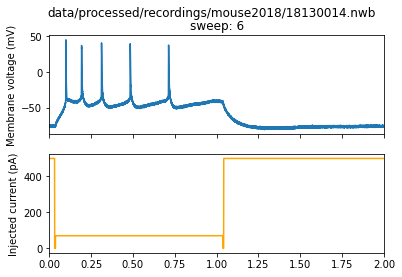

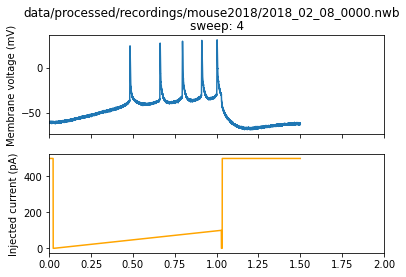

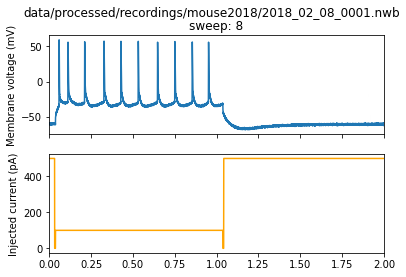

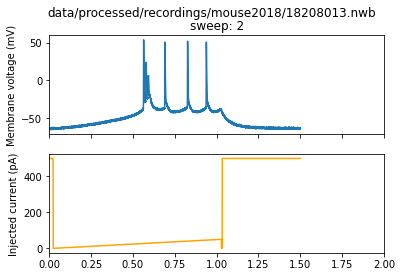

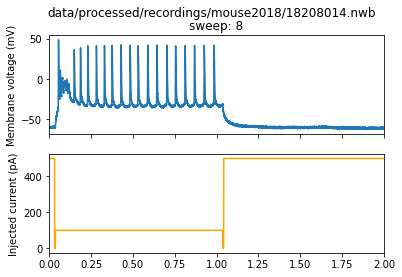

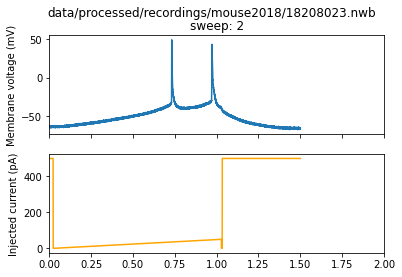

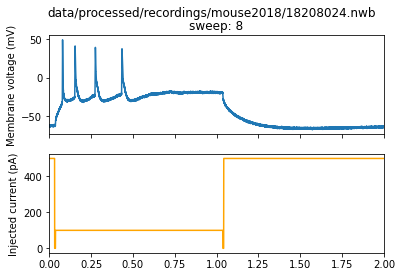

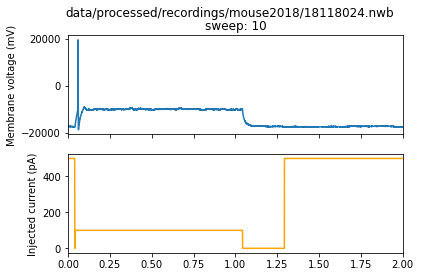

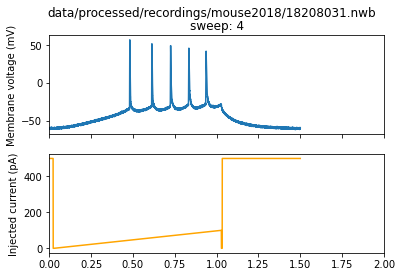

In [30]:
for i, row in successes_df.iterrows():
    utils.plot_nwb_sweep(row.nwb_path, './data/stim_ontology_new_Homeira.json') 

## Validate

In [31]:
!dandi validate "data/processed/recordings/mouse2018"

2021-07-28 15:26:52,483 [ WARNING] A newer version (0.25.0) of dandi/dandi-cli is available. You are using 0.23.2
2021-07-28 15:26:57,778 [    INFO] data/processed/recordings/mouse2018/18118024.nwb: ok
2021-07-28 15:27:01,172 [    INFO] data/processed/recordings/mouse2018/18208014.nwb: ok
2021-07-28 15:27:03,830 [    INFO] data/processed/recordings/mouse2018/18208013.nwb: ok
2021-07-28 15:27:06,395 [    INFO] data/processed/recordings/mouse2018/18208023.nwb: ok
2021-07-28 15:27:09,588 [    INFO] data/processed/recordings/mouse2018/18208024.nwb: ok
2021-07-28 15:27:12,181 [    INFO] data/processed/recordings/mouse2018/18208031.nwb: ok
2021-07-28 15:27:14,682 [    INFO] data/processed/recordings/mouse2018/2018_02_08_0001.nwb: ok
2021-07-28 15:27:17,020 [    INFO] data/processed/recordings/mouse2018/2018_02_08_0000.nwb: ok
2021-07-28 15:27:19,333 [    INFO] data/processed/recordings/mouse2018/18130014.nwb: ok
Summary: No validation errors among 9 file(s)
2021-07-28 15:27:19,333 [    INFO]

## Extract stimulus info to later merge with metadata

In [32]:
converted_nwb_paths = list(Path('data/processed/recordings/mouse2018').glob('*.nwb'))
converted_nwb_file_ids = [x.stem for x in converted_nwb_paths]
to_extract_stim_info = mouse2018_file_info[mouse2018_file_info.file_id.isin(converted_nwb_file_ids)]

In [33]:
to_extract_stim_info

,file_name,path,timestamp,abf_version,abf_comments,file_id
22,18130014.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-30 15:57:40.031,1.8.3.0,"[C5, L5, RMP: -75.2 mv]",18130014
39,18208014.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 14:45:29.781,1.8.3.0,"[C3 RMP -62.3mv;layer 5,]",18208014
40,18208013.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 14:45:14.687,1.8.3.0,"[C3 RMP -62.3mv;layer 5,]",18208013
44,18208023.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 17:12:06.421,1.8.3.0,"[C6 RMP -63..2 mv;layer 5,]",18208023
45,18208024.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 17:12:25.687,1.8.3.0,"[C6 RMP -63..2 mv;layer 5,, C6 RMP -63..2 mv;l...",18208024
49,18208031.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 18:24:21.140,1.8.3.0,"[C9; RMP -62.4 mv;layer 5, offset -20.1 mv, C...",18208031
57,2018_02_08_0000.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 12:57:10.781,1.8.3.0,[],2018_02_08_0000
58,2018_02_08_0001.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-02-08 12:58:48.218,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",2018_02_08_0001
117,18118024.abf,data/raw/recordings/Mouse data/Mouse data_2018...,2018-01-18 14:11:46.671,1.8.3.0,"[C4, L5, RMP: --59.4 mv]",18118024


In [34]:
# parse relevant info related to stimulus, including duration, and amplitudes
def get_stim_info(abf_path, stim_channel_num = 1, stim_gain = 1, stim_name = 'sweepC'):
    abf = pyabf.ABF(abf_path)
    num_sweeps = abf.sweepCount
    stim_amps = np.zeros(num_sweeps) 
    stim_start_time = None
    stim_end_time = None
    sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

    for i in range(0, num_sweeps):
        abf.setSweep(i, channel=stim_channel_num)
        sampling_rate = abf.dataRate
        if stim_name == 'sweepY':
            stim_vec = np.round(abf.sweepY * stim_gain)
        else:
            stim_vec = np.round(abf.sweepC * stim_gain)
        stim_amp = stim_vec[5000]

        stim_amps[i] = round(stim_amp)
        non_zero_inds = np.where(stim_vec == stim_amp)
        stim_duration = np.shape(non_zero_inds)[1] * 1/sampling_rate
        if stim_duration == 0:
            continue
        stim_start_ind = non_zero_inds[0][0]
        stim_end_ind = non_zero_inds[0][-1]
        
        stim_start_time = abf.sweepX[stim_start_ind]
        stim_end_time = abf.sweepX[stim_end_ind]

    ret_dict = {'stim_amp_vec' : stim_amps, 'stim_duration' : stim_duration, 
                'stim_start_time' : stim_start_time, 'stim_end_time' : stim_end_time, 'num_sweeps' : num_sweeps,
               'stim_sampling_rate' : sampling_rate}
    return(ret_dict)
    """
    return pd.Series([stim_amps, stim_duration, stim_start_time, stim_end_time, num_sweeps, sampling_rate], 
                     index=['stim_amp_vec', 'stim_duration', 'stim_start_time', 'stim_end_time', 'num_sweeps', 'stim_sampling_rate'])
    """

In [35]:
stim_info = {}
for i, row in to_extract_stim_info.iterrows():
    try:
        abf_info = get_stim_info(row.path, stim_name = 'sweepC')
    except (AttributeError, ValueError, IndexError) as e:
        print(e)
        abf_info = None
    stim_info[row.file_name] = abf_info
    
stim_info_df = pd.DataFrame(stim_info).T

In [36]:
stim_info_df

,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
18130014.abf,"[-50.0, -30.0, -10.0, 10.0, 30.0, 50.0, 70.0, ...",1.0,0.0372,1.0371,11,10000
18208014.abf,"[-220.0, -180.0, -140.0, -100.0, -60.0, -20.0,...",1.0,0.0372,1.0371,13,10000
18208013.abf,"[0.0, 12.0, 24.0, 35.0, 47.0]",0.01,0.4934,0.5033,5,10000
18208023.abf,"[0.0, 12.0, 24.0, 35.0, 47.0]",0.01,0.4934,0.5033,5,10000
18208024.abf,"[-220.0, -180.0, -140.0, -100.0, -60.0, -20.0,...",1.0,0.0372,1.0371,12,10000
18208031.abf,"[0.0, 12.0, 24.0, 35.0, 47.0, 59.0]",0.008,0.4964,0.5043,6,10000
2018_02_08_0000.abf,"[0.0, 12.0, 24.0, 35.0, 47.0, 59.0, 71.0]",0.0067,0.4984,0.505,7,10000
2018_02_08_0001.abf,"[-220.0, -180.0, -140.0, -100.0, -60.0, -20.0,...",1.0,0.0372,1.0371,14,10000
18118024.abf,"[-400.0, -350.0, -300.0, -250.0, -200.0, -150....",1.0,0.0428,1.04275,16,20000


In [37]:
stim_info_dir = Path('./data/processed/meta/stiminfo/')
stim_info_dir.mkdir(exist_ok=True)
stim_info_df.index.name = 'abf_filename'
stim_info_df.to_csv(stim_info_dir / 'mouse2018_stiminfo.csv')